# Assignment 4: Image Classification
#### INSERT YOUR NAME AND ID HERE
In this assignment, we will build a convolutional neural network that can predict
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network mostly by yourself.

When you are finished with the assignment make sure you submit the following files:
1. this file (ML_DL_Assignment4.ipynb) compressed to zip.
2. the functions file (ML_DL_Functions4.py).
3. the model parameters for the first model from section 3.3 ('best_CNN_model.pk').
4. the model parameters for the second model from section 3.3 ('best_CNNChannel_model.pk').

## Grading Method
In this assignment you are given alot more freedom to implement your own models and training proccedures. Yet we still need an automatic method for testing your codes. This means that there are a few things which have to be done correctly in order for the testing to pass:
1. Your preprocessing has to be exactly the same as the preprocessing done on the test set. To ensure this happens you got a small sample of validation images to compare your preprocessing to the test.
2. your models have to be written in pytorch, they have to accept the correct input shape and output the correct shape and type.
3. your models will be instantiated on the testing server without any arguments so make sure to not include any in your models.
4. The values in the output of the model should have the correct meaning. For that reason you were given a prewritten get_accuracy function. make sure it works with your model without changing the function.

Your grade will be assessed only according to the accuracy of your model *(not including a sampled check that you did submit your code and finished the assignment).
Since there are only two possible classes (same pair and different pair) you will be compared to a random choice, meaning that an accuracy of 50% is just guessing and will result in a minimal grade. The grade itself will be a linear function of your accuracy with a set minimum grade (yet to be determined).
As you will see in the following assignment, we will track two accuracies (for same pair and different pairs separately). The accuracy that will determine your grade is the average of these two accuracies (positive accuracy + negative accuracy)/2. This means that if your model has a positive accuracy of 100% but a negative accuracy of 0% (model always predicts same pair) your average accuracy will be 50% which is no improvement from random choice.

You will also note during the assignment that we are tracking men’s and women’s shoes separately. You will be graded separately for the men's and women’s shoes since each they have different difficulties.


In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sys
from PIL import Image

def reload_functions():
  if 'ML_DL_Functions4' in sys.modules:
    del sys.modules['ML_DL_Functions4']
  functions_path = drive_path.replace(" ","\ ") + 'ML_DL_Functions4.py'
  !cp $functions_path .

## 1. Data

Download the data from the course website. make sure you have both the template python functions file and the dataset data directory on the same directory in your google drive.

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = '/content/gdrive/My Drive/Machine learning/Assignment4/' # TODO - UPDATE ME!

Mounted at /content/gdrive


After you have done so, read this entire section
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### 1.1 Loading and Preprocessing the data

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair.
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `Image.open`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed.
**The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1.** Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [3]:
import os
import glob
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# 1) Load the train images
# ----------------------------------------------------------------------------
path = drive_path + "data/train/*.jpg"
# Dictionary: person_part -> [ [None, None], [None, None], [None, None] ]
# where index [0..2] = pair number, and [L=0, R=1]
train_dict = {}

for file in glob.glob(path):
    filename = file.split("/")[-1]  # e.g. "u001_1_left_w.jpg"

    # Remove .jpg
    base_name = filename.replace('.jpg', '')  # "u001_1_left_w"
    parts = base_name.split('_')              # ["u001", "1", "left", "w"]

    person_part = parts[0]  # "u001"
    pair_str = parts[1]     # "1"
    side_str = parts[2]     # "left" or "right"
    # the last part is "w" (women) or "m" (men), we'll ignore or store as needed

    # Convert pair_str -> integer. If your data has pairs "1,2,3",
    # you can subtract 1 so they become indices [0..2].
    pair_idx = int(pair_str) - 1  # so "1" -> 0, "2" -> 1, "3" -> 2

    # Map "left" -> 0, "right" -> 1
    side_idx = 0 if side_str == 'left' else 1

    # Load the image with PIL, remove alpha channel by converting to RGB
    img_pil = Image.open(file).convert('RGB')
    # Resize to 224x224 if needed:
    img_pil = img_pil.resize((224, 224), resample=Image.Resampling.LANCZOS)

    # Convert to numpy
    img_arr = np.asarray(img_pil, dtype=np.float32)
    # Normalize [0..1] and shift to [-0.5..0.5]
    img_arr /= 255.0
    img_arr -= 0.5

    # Make a 3x2 storage if this person not yet in dictionary
    if person_part not in train_dict:
        train_dict[person_part] = [
            [None, None],  # pair 0
            [None, None],  # pair 1
            [None, None]   # pair 2
        ]

    train_dict[person_part][pair_idx][side_idx] = img_arr

# Now convert each person's 3x2 list-of-lists to a NumPy array (3,2,224,224,3).
for k in train_dict.keys():
    train_dict[k] = np.array(train_dict[k], dtype=np.float32)

# Create train_data/valid_data split
all_people = list(train_dict.keys())
random.shuffle(all_people)

val_size = int(0.2 * len(all_people))
valid_keys = all_people[:val_size]
train_keys = all_people[val_size:]

train_data = np.array([train_dict[k] for k in train_keys])
valid_data = np.array([train_dict[k] for k in valid_keys])

# For test sets, you'd do something similar, e.g.:
path_test_m = drive_path + "data/test_m/*.jpg"
test_m_dict = {}

for file in glob.glob(path_test_m):
    filename = file.split("/")[-1]
    base_name = filename.replace('.jpg', '')
    parts = base_name.split('_')  # e.g. ["u005", "2", "right", "m"]

    person_part = parts[0]
    pair_idx = int(parts[1]) - 1
    side_str = parts[2]
    side_idx = 0 if side_str == 'left' else 1

    img_pil = Image.open(file).convert('RGB')
    img_pil = img_pil.resize((224, 224), resample=Image.Resampling.LANCZOS)
    img_arr = np.asarray(img_pil, dtype=np.float32)
    img_arr /= 255.0
    img_arr -= 0.5

    if person_part not in test_m_dict:
        test_m_dict[person_part] = [
            [None, None],
            [None, None],
            [None, None]
        ]
    test_m_dict[person_part][pair_idx][side_idx] = img_arr

for k in test_m_dict.keys():
    test_m_dict[k] = np.array(test_m_dict[k], dtype=np.float32)

test_m_data = np.array(list(test_m_dict.values()))

# Similarly for test_w
path_test_w = drive_path + "data/test_w/*.jpg"
test_w_dict = {}

for file in glob.glob(path_test_w):
    filename = file.split("/")[-1]
    base_name = filename.replace('.jpg', '')
    parts = base_name.split('_')  # e.g. ["u007", "3", "left", "w"]

    person_part = parts[0]
    pair_idx = int(parts[1]) - 1
    side_str = parts[2]
    side_idx = 0 if side_str == 'left' else 1

    img_pil = Image.open(file).convert('RGB')
    img_pil = img_pil.resize((224, 224), resample=Image.Resampling.LANCZOS)
    img_arr = np.asarray(img_pil, dtype=np.float32)
    img_arr /= 255.0
    img_arr -= 0.5

    if person_part not in test_w_dict:
        test_w_dict[person_part] = [
            [None, None],
            [None, None],
            [None, None]
        ]
    test_w_dict[person_part][pair_idx][side_idx] = img_arr

for k in test_w_dict.keys():
    test_w_dict[k] = np.array(test_w_dict[k], dtype=np.float32)

test_w_data = np.array(list(test_w_dict.values()))

# Print final shapes
print("train_data shape:", train_data.shape)
print("valid_data shape:", valid_data.shape)
print("test_m_data shape:", test_m_data.shape)
print("test_w_data shape:", test_w_data.shape)

# Optionally save .npy
# np.save("train_data.npy", train_data)
# np.save("valid_data.npy", valid_data)
# np.save("test_m_data.npy", test_m_data)
# np.save("test_w_data.npy", test_w_data)

# ----------------------------------------------------------------------------
# 2) Compare Preprocessed Validation Images with Reference Samples
# ----------------------------------------------------------------------------
def compare_preprocessed_validation(valid_data, reference_file_paths, num_samples=3):
    """
    Compare your preprocessed validation images with reference preprocessed test images.

    Args:
        valid_data (numpy.ndarray): Your preprocessed validation data.
            Shape: (num_valid_people, 3, 2, 224, 224, 3)
        reference_file_paths (list of str): Paths to the reference preprocessed test .npy files.
        num_samples (int): Number of samples to compare. Default is 3.
    """
    import matplotlib.pyplot as plt

    # Load reference samples
    reference_samples = []
    for fp in reference_file_paths:
        ref_sample = np.load(fp)
        reference_samples.append(ref_sample)
        print(f"Loaded {fp} with shape {ref_sample.shape}")

    # Ensure num_samples does not exceed available samples
    num_samples = min(num_samples, len(reference_samples), valid_data.shape[0])

    plt.figure(figsize=(18, 6 * num_samples))

    for i in range(num_samples):
        ref_sample = reference_samples[i]      # Expected shape: (3, 2, 224, 224, 3)
        val_sample = valid_data[i]             # Shape: (3, 2, 224, 224, 3)

        # Validate shapes
        if ref_sample.shape != (3, 2, 224, 224, 3):
            print(f"Reference sample {i+1} has unexpected shape {ref_sample.shape}. Skipping.")
            continue

        for pair_idx in range(3):  # Assuming 3 pairs
            for side_idx in range(2):  # Left and Right
                ref_image = ref_sample[pair_idx][side_idx] + 0.5  # Denormalize for visualization
                val_image = val_sample[pair_idx][side_idx] + 0.5  # Denormalize for visualization

                # Ensure pixel values are within [0,1]
                ref_image = np.clip(ref_image, 0, 1)
                val_image = np.clip(val_image, 0, 1)

                # Compute Mean Absolute Error
                mae = np.mean(np.abs(ref_image - val_image))

                # Plot Reference Image
                plt.subplot(num_samples * 3, 4, (i * 6) + (pair_idx * 2) * 2 + 1)
                plt.imshow(ref_image)
                plt.title(f'Reference Test {i+1} Pair {pair_idx+1} Side {"Left" if side_idx == 0 else "Right"}')
                plt.axis('off')

                # Plot Your Preprocessed Validation Image
                plt.subplot(num_samples * 3, 4, (i * 6) + (pair_idx * 2) * 2 + 2)
                plt.imshow(val_image)
                plt.title(f'Your Preprocessed Val {i+1} Pair {pair_idx+1} Side {"Left" if side_idx == 0 else "Right"}\nMAE: {mae:.4f}')
                plt.axis('off')

                # Plot Difference Heatmap
                diff = np.abs(ref_image - val_image)
                plt.subplot(num_samples * 3, 4, (i * 6) + (pair_idx * 2) * 2 + 3)
                plt.imshow(diff, cmap='hot')
                plt.title(f'Difference Heatmap\nPair {pair_idx+1} Side {"Left" if side_idx == 0 else "Right"}')
                plt.axis('off')

                # Plot Histogram of Differences
                plt.subplot(num_samples * 3, 4, (i * 6) + (pair_idx * 2) * 2 + 4)
                plt.hist(diff.flatten(), bins=50, color='gray')
                plt.title(f'Difference Histogram\nMAE: {mae:.4f}')
                plt.xlabel('Absolute Difference')
                plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Define paths to the reference preprocessed validation test files

reference_file_paths = [
    os.path.join(drive_path, "data","preproccessing_validation","preproccessing_validation_test1.npy"),
    os.path.join(drive_path, "data", "preproccessing_validation","preproccessing_validation_test2.npy"),
    os.path.join(drive_path, "data", "preproccessing_validation","preproccessing_validation_test3.npy"),
]


# Ensure that the reference files exist
for fp in reference_file_paths:
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Reference file {fp} not found. Please ensure the file exists in the specified directory.")

# Call the comparison function
compare_preprocessed_validation(valid_data, reference_file_paths, num_samples=3)


train_data shape: (90, 3, 2, 224, 224, 3)
valid_data shape: (22, 3, 2, 224, 224, 3)
test_m_data shape: (10, 3, 2, 224, 224, 3)
test_w_data shape: (10, 3, 2, 224, 224, 3)
Loaded /content/gdrive/My Drive/Machine learning/Assignment4/data/preproccessing_validation/preproccessing_validation_test1.npy with shape (224, 224, 3)
Loaded /content/gdrive/My Drive/Machine learning/Assignment4/data/preproccessing_validation/preproccessing_validation_test2.npy with shape (224, 224, 3)
Loaded /content/gdrive/My Drive/Machine learning/Assignment4/data/preproccessing_validation/preproccessing_validation_test3.npy with shape (224, 224, 3)
Reference sample 1 has unexpected shape (224, 224, 3). Skipping.
Reference sample 2 has unexpected shape (224, 224, 3). Skipping.
Reference sample 3 has unexpected shape (224, 224, 3). Skipping.


<Figure size 1800x1800 with 0 Axes>

preprocessing error, make sure you followed all instructions carefully


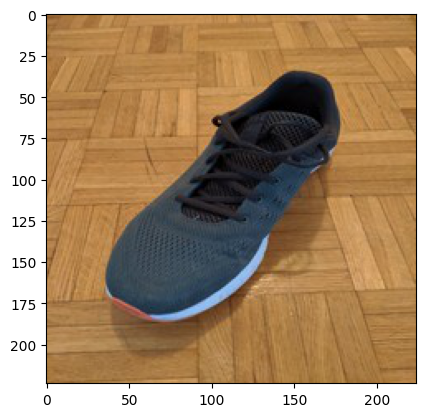

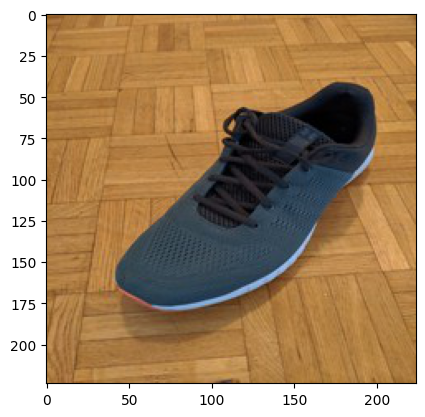

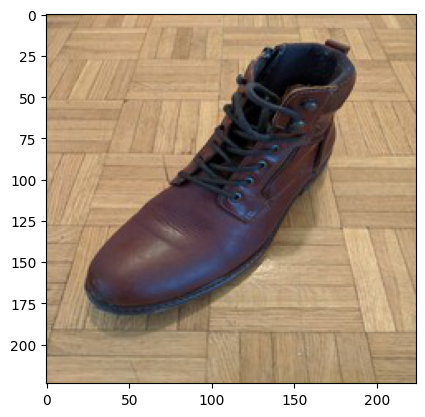

In [4]:
# Run this code
test1 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test1.npy")
test2 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test2.npy")
test3 = np.load(drive_path+"data/preproccessing_validation/preproccessing_validation_test3.npy")
if (test1 != train_data[4,0,1,:,:,:]).any() or \
   (test2 != train_data[4,0,0,:,:,:]).any() or \
   (test3 != train_data[4,1,0,:,:,:]).any():
   print("preprocessing error, make sure you followed all instructions carefully")

plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,0,:,:,:]+0.5) # left shoe of second pair submitted by 5th student

### 1.2 Generating Same Pairs

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


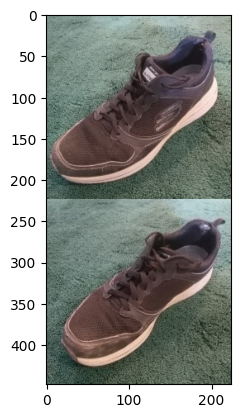

In [5]:
# Your code goes here
import numpy as np

def generate_same_pair(data):
    """
    data is expected to have shape [N, 3, 2, 224, 224, 3].
      - N: number of triplets
      - 3: number of pairs per triplet
      - 2: left shoe (0) and right shoe (1)
      - 224, 224: height and width of each image
      - 3: color channels (RGB)

    Returns a numpy array of shape [N*3, 448, 224, 3], where each entry
    is formed by taking the left shoe and right shoe from one pair and
    concatenating them along the height dimension (axis=0).
    """
    out_list = []
    N = data.shape[0]

    for i in range(N):
        for j in range(3):
            # left shoe => [224, 224, 3]
            left_img = data[i, j, 0, :, :, :]
            # right shoe => [224, 224, 3]
            right_img = data[i, j, 1, :, :, :]

            # Concatenate along axis=0 (the "height" axis):
            # Result => [224+224, 224, 3] => [448, 224, 3]
            combined = np.concatenate((left_img, right_img), axis=0)
            out_list.append(combined)

    # Stack into a single array => shape [N*3, 448, 224, 3]
    return np.array(out_list, dtype=np.float32)


# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### 1.3 Generate Different Pairs

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.
Make sure you randomly choose 3 wrong pairs between **all** six options otherwise your model will learn from a subset of the wrong pairs and will have a lower accuracy.

(90, 3, 2, 224, 224, 3)
(270, 448, 224, 3)


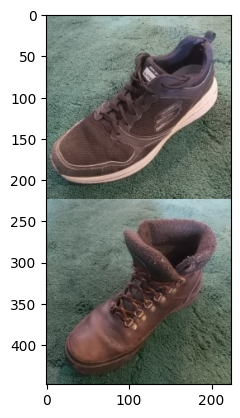

In [6]:
# Your code goes here
import random
import numpy as np

def generate_different_pair(data):
    """
    data shape: [N, 3, 2, 224, 224, 3]
      - N: number of triplets (persons)
      - 3: the 3 pairs of shoes for each person
      - 2: left shoe (index 0) and right shoe (index 1)
      - 224, 224: height, width
      - 3: RGB channels

    Returns:
      A numpy array of shape [N*3, 448, 224, 3],
      where for each triplet/person, we randomly choose 3 distinct
      mismatched combinations from the 6 possible (left from pair i,
      right from pair j, i != j).
    """

    # Possible mismatches among 3 pairs: left from i, right from j
    # i in {0,1,2}, j in {0,1,2}, i != j => 6 combinations
    mismatch_combos = [(0,1), (0,2), (1,0), (1,2), (2,0), (2,1)]

    N = data.shape[0]
    out_list = []

    for i in range(N):
        # Randomly pick exactly 3 mismatch combos out of the 6
        chosen_combos = random.sample(mismatch_combos, 3)
        for (left_pair, right_pair) in chosen_combos:
            # left shoe from left_pair
            left_img = data[i, left_pair, 0, :, :, :]  # shape [224,224,3]
            # right shoe from right_pair
            right_img = data[i, right_pair, 1, :, :, :] # shape [224,224,3]

            # Concatenate along axis=0 (height), giving [224+224, 224, 3] => [448,224,3]
            combined = np.concatenate((left_img, right_img), axis=0)

            out_list.append(combined)

    # Shape => [N*3, 448, 224, 3]
    return np.array(out_list, dtype=np.float32)


# Run this code
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

#### Food for thought

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

***We want to ensure the only difference between shoes is that they come from different pairs—not from different people who might have different backgrounds, lighting, shoe style, etc. By restricting “different pairs” to the same person, we isolate the distinction to the actual pair difference rather than extraneous factors.***
***If 99% of the samples are “not same pair,” a naive model could always predict “different” and still get 99% accuracy, which is useless. Balancing ensures the model actually learns to detect the “same” class rather than exploiting label imbalance.***

## 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.



### 2.1 Convolutional Model

Open the functions file(ML_DL_Functions4.py) and Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

make sure the CNN's constructor(__init__) function has no arguments. Instantiate the variable $n$ inside the constructor(__init__) of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.
make sure the output of the model has a shape of (N,2) where N is the batch_size.

### 2.2 Channeled Convolutional Neural Network

Open the functions file(ML_DL_Functions4.py) and Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

make sure the output of the model has a shape of (N,2) where N is the batch_size.

#### Food for thought

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. why would one of these models perform better?
***Because CNNChannel directly combines the left and right shoes in the channel dimension, it may more naturally learn cross-shoe features that help it recognize “same pair” vs. “different pair.” By contrast, a standard CNN sees two vertically stacked images, which can make it harder to capture interaction between left and right shoes. Hence, architecture nuances—in how data is fused—can lead to better performance even if both networks have similar parameter counts.***

### 2.3 Get Accuracy

The function `get_accuracy` is written for you. Make sure your code works with this version of the function without changing it because in the grading process this function will be used.

Unlike in the previous assignment, here we will separately compute the model accuracy on the
positive and negative samples.

In [7]:
def get_accuracy(model, data, batch_size=50,device='cpu'):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()

    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).permute(0,3,1,2)
        xs = xs.to(device)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

#### Food for thought
why do we wish to track the false positives and false negatives separately?

## 3. Training

Now, we will write the functions required to train the model.

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target. We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### 3.1 train model

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image.
- computing the forward and backward passes
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import copy
from sklearn.utils.class_weight import compute_class_weight

# EXAMPLE CUSTOM LR SCHEDULER
# ---------------------------------------------------
class CustomLRScheduler:
    def __init__(self, optimizer, increase_factor=1.05, decrease_factor=0.5, min_lr=1e-6,
                 max_lr=1.0, patience=5, low_accuracy_threshold=0.6,
                 stability_threshold=0.02, window_size=5, cooldown=2):
        self.optimizer = optimizer
        self.increase_factor = increase_factor
        self.decrease_factor = decrease_factor
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.patience = patience
        self.low_accuracy_threshold = low_accuracy_threshold
        self.stability_threshold = stability_threshold
        self.window_size = window_size
        self.cooldown = cooldown
        self.cooldown_counter = 0

        self.accuracy_history = []
        self.best_accuracy = 0.0
        self.num_bad_epochs = 0

    def step(self, pos_val_acc, neg_val_acc, current_accuracy):
        """Adjust learning rate based on pos/neg val accuracy & average accuracy."""
        # Respect cooldown period
        if self.cooldown_counter > 0:
            self.cooldown_counter -= 1
            return

        # Add current accuracy to history
        self.accuracy_history.append(current_accuracy)
        if len(self.accuracy_history) > self.window_size:
            self.accuracy_history.pop(0)

        # Check for polarization: e.g., 100% vs 0%
        if (pos_val_acc > 0.99 and neg_val_acc < 0.01) or (pos_val_acc < 0.01 and neg_val_acc > 0.99):
            print("Polarization detected, reducing learning rate.")
            self._decrease_lr()
            return

        # Check moving average improvement
        moving_avg = np.mean(self.accuracy_history)
        if moving_avg > self.best_accuracy + self.stability_threshold:
            self.best_accuracy = moving_avg
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1

        # Condition 1: Low accuracy → Increase LR
        if moving_avg < self.low_accuracy_threshold and self.num_bad_epochs >= self.patience:
            self._increase_lr()
            self.num_bad_epochs = 0
            self.cooldown_counter = self.cooldown
            return

        # Condition 2: Unstable accuracy → Decrease LR
        if np.std(self.accuracy_history) > self.stability_threshold and self.num_bad_epochs >= self.patience:
            self._decrease_lr()
            self.num_bad_epochs = 0
            self.cooldown_counter = self.cooldown
            return

    def _increase_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = min(old_lr * self.increase_factor, self.max_lr)
            param_group['lr'] = new_lr
            print(f"Learning rate increased from {old_lr:.6f} to {new_lr:.6f}")

    def _decrease_lr(self):
        for param_group in self.optimizer.param_groups:
            old_lr = param_group['lr']
            new_lr = max(old_lr * self.decrease_factor, self.min_lr)
            param_group['lr'] = new_lr
            print(f"Learning rate decreased from {old_lr:.6f} to {new_lr:.6f}")


# ---------------------------------------------------

def train_model(model,
               train_data,          # Original triplet-based data [N,3,2,224,224,3]
               validation_data,     # Same format as train_data (for validation)
               batch_size=32,
               learning_rate=1e-3,
               weight_decay=1e-5,
               epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    best_model_state = None

    # (1) Generate positive/negative data
    pos_data = generate_same_pair(train_data)
    neg_data = generate_different_pair(train_data)
    pos_size = pos_data.shape[0]
    neg_size = neg_data.shape[0]

    # (2) Compute class weights
    train_labels = np.concatenate((np.ones(pos_size, dtype=np.int64),
                                   np.zeros(neg_size, dtype=np.int64)))
    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(train_labels),
                                         y=train_labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # (3) Define loss, optimizer, and custom scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = CustomLRScheduler(
        optimizer,
        increase_factor=1.05,
        decrease_factor=0.5,
        min_lr=1e-6,
        max_lr=1.0,
        patience=5,
        low_accuracy_threshold=0.6,
        stability_threshold=0.02,
        window_size=5,
        cooldown=2
    )

    previous_lr = optimizer.param_groups[0]['lr']

    for epoch in range(epochs):
        model.train()
        epoch_train_correct = 0
        epoch_train_total = 0

        # Shuffle pos/neg
        pos_indices = np.random.permutation(pos_size)
        neg_indices = np.random.permutation(neg_size)

        half_bs = batch_size // 2
        for i in range(0, pos_size, half_bs):
            pos_left = pos_size - i
            neg_left = neg_size - i
            pos_take = min(pos_left, half_bs)
            neg_take = min(neg_left, half_bs)

            if pos_take == 0 or neg_take == 0:
                break

            pos_batch_inds = pos_indices[i : i + pos_take]
            neg_batch_inds = neg_indices[i : i + neg_take]

            x_pos = pos_data[pos_batch_inds]
            x_neg = neg_data[neg_batch_inds]

            x_batch = np.concatenate((x_pos, x_neg), axis=0)
            y_batch = np.concatenate((np.ones(pos_take, dtype=np.int64),
                                      np.zeros(neg_take, dtype=np.int64)), axis=0)

            x_batch_torch = torch.from_numpy(x_batch).permute(0, 3, 1, 2).float().to(device)
            y_batch_torch = torch.from_numpy(y_batch).long().to(device)

            optimizer.zero_grad()
            outputs = model(x_batch_torch)
            loss = criterion(outputs, y_batch_torch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            epoch_train_correct += (preds == y_batch_torch).sum().item()
            epoch_train_total += y_batch_torch.size(0)

        train_acc = epoch_train_correct / epoch_train_total

        # (5) Validation
        pos_val_acc, neg_val_acc = get_accuracy(model, validation_data, batch_size=batch_size, device=device)
        avg_val_acc = (pos_val_acc + neg_val_acc) / 2.0

        # (6) Step our custom scheduler with pos_val_acc, neg_val_acc, and average val accuracy
        scheduler.step(pos_val_acc, neg_val_acc, avg_val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Acc: {train_acc*100:.2f}% | "
              f"Pos Val Acc: {pos_val_acc*100:.2f}% | Neg Val Acc: {neg_val_acc*100:.2f}% | "
              f"Avg Val Acc: {avg_val_acc*100:.2f}%")

        # (7) Check best accuracy
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"New best model state stored with Avg Val Acc: {best_val_acc*100:.2f}%")

        # (8) Log learning rate if changed
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != previous_lr:
            print(f"Learning rate adjusted from {previous_lr:.6f} to {current_lr:.6f}")
            previous_lr = current_lr

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best model state loaded into the model (Avg Val Acc: {best_val_acc*100:.2f}%).")

    return {
        "pos_val_acc": pos_val_acc,
        "neg_val_acc": neg_val_acc,
        "avg_val_acc": avg_val_acc,
        "model": model
    }


### 3.2 Sanity check

Sanity check your code from 3.1 and from 2.1 and 2.2 by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ training accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [12]:
reload_functions()
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ML_DL_Functions4
from ML_DL_Functions4 import CNNChannel  # Ensure this imports the updated CNNChannel

# Assume generate_same_pair and generate_different_pair are defined
# Also, ensure that train_data is defined

# 1) Generate the pairs
tiny_triplets = train_data[:2]  # Pick just 2 triplets
pos_data_tiny = generate_same_pair(tiny_triplets)       # shape => [6, 448,224,3]
neg_data_tiny = generate_different_pair(tiny_triplets)  # shape => [6,448,224,3]

# We only want ~5 images from pos and ~5 from neg to keep it extremely small
pos_data_tiny = pos_data_tiny[:5]
neg_data_tiny = neg_data_tiny[:5]

print("pos_data_tiny shape:", pos_data_tiny.shape)  # Expected: (5, 448, 224, 3)
print("neg_data_tiny shape:", neg_data_tiny.shape)  # Expected: (5, 448, 224, 3)

# 2) Initialize the model
model = CNNChannel()
model.train()

# 3) Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# 4) Training parameters
num_iterations = 30
batch_size = 10  # Single batch containing all 5 pos + 5 neg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 5) Create the single “batch” for convenience
#    - half from pos, half from neg
x_tiny = np.concatenate([pos_data_tiny, neg_data_tiny], axis=0)  # shape => (10,448,224,3)
y_tiny = np.concatenate([np.ones(5, dtype=np.int64), np.zeros(5, dtype=np.int64)], axis=0)  # shape => (10,)

# 6) Convert to PyTorch Tensors
x_tiny_torch = torch.from_numpy(x_tiny).permute(0,3,1,2).float().to(device)  # (10,3,448,224)
y_tiny_torch = torch.from_numpy(y_tiny).long().to(device)  # Use long for CrossEntropyLoss

# 7) Training Loop
for iteration in range(num_iterations):
    # Forward
    optimizer.zero_grad()
    outputs = model(x_tiny_torch)  # shape => (10,2)
    loss = criterion(outputs, y_tiny_torch)

    # Backward
    loss.backward()
    optimizer.step()

    # Compute accuracy on this tiny set
    with torch.no_grad():
        preds = torch.argmax(outputs, dim=1)
        correct = (preds == y_tiny_torch).sum().item()
        acc = 100.0 * correct / y_tiny_torch.shape[0]

    if (iteration+1) % 5 == 0:
        print(f"Iteration {iteration+1}/{num_iterations} - "
              f"Loss: {loss.item():.4f}, "
              f"Acc: {acc:.2f}%")

# Expect that Acc quickly becomes 90-100% on this tiny set


pos_data_tiny shape: (5, 448, 224, 3)
neg_data_tiny shape: (5, 448, 224, 3)
Iteration 5/30 - Loss: 0.6703, Acc: 70.00%
Iteration 10/30 - Loss: 0.2670, Acc: 90.00%
Iteration 15/30 - Loss: 1.4758, Acc: 70.00%
Iteration 20/30 - Loss: 0.2166, Acc: 90.00%
Iteration 25/30 - Loss: 0.1838, Acc: 90.00%
Iteration 30/30 - Loss: 0.0587, Acc: 100.00%


### 3.3 training and saving the optimal model

Train your models from Q2(a) and Q2(b). Change the values of a few
hyperparameters, including the learning rate, batch size, choice of $n$, and
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, choose your hyperparameters run the training and save the model in the drive. You should try to save the your **single best** model.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using.  Remember to submit the model with your code in the moodle submission.

It is recommended to plot the training curves.

In [26]:
# Insert your training code here as provided
reload_functions()
import ML_DL_Functions4
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Instantiate the two model blueprints
CNN_model = ML_DL_Functions4.CNN()         # Blueprint for CNN model (no arguments)
CNNChannel_model = ML_DL_Functions4.CNNChannel()  # Blueprint for CNNChannel model (no arguments)

# If you're using Colab and want to save best models to Drive, mount it:
# from google.colab import drive
# drive.mount('/content/drive')

# Make sure you have your train_data and valid_data from part (a)
# e.g. train_data.shape = [N, 3, 2, 224, 224, 3]
#      valid_data.shape = [M, 3, 2, 224, 224, 3]

# Directory to save checkpoints
checkpoint_dir = "/content/drive/MyDrive/Machine learning/Assignment4/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)


##############################################################################
# Function to run experiments with different hyperparameters.
##############################################################################
def run_experiment(model,
                   lr, batch_size, weight_decay, epochs,
                   train_data, valid_data,
                   checkpoint_dir,
                   experiment_name):

    print(f"=== Starting experiment: {experiment_name} ===")
    print(f"Hyperparams => lr={lr}, batch_size={batch_size}, weight_decay={weight_decay}, epochs={epochs}\n")

    results = train_model(
        model=model,
        train_data=train_data,
        validation_data=valid_data,
        batch_size=batch_size,
        learning_rate=lr,
        weight_decay=weight_decay,
        epochs=epochs  # where to save model at each epoch
    )

    # The train_model function returns a dictionary with training curves and accuracy metrics.
    avg_val_acc = results["avg_val_acc"]

    print(f"Final Average Validation Accuracy: {avg_val_acc*100:.2f}%\n")
    return results

##############################################################################
# 2a) Let's try big changes for CNN_model
##############################################################################
# Choose hyperparameters to experiment with.

learning_rates = [0.000032]
batch_sizes = [64]
weight_decays = [0.0001]
num_epochs = 80

all_results_cnn = []  # list to store tuples (lr, bs, wd, result_dict)

for lr in learning_rates:
    for bs in batch_sizes:
        for wd in weight_decays:
            # IMPORTANT: Re-instantiate a fresh model each time.
            model_cnn = ML_DL_Functions4.CNN()

            experiment_name = f"CNN_lr{lr}_bs{bs}_wd{wd}"
            result_dict = run_experiment(
                model=model_cnn,
                lr=lr,
                batch_size=bs,
                weight_decay=wd,
                epochs=num_epochs,
                train_data=train_data,
                valid_data=valid_data,
                checkpoint_dir=checkpoint_dir,
                experiment_name=experiment_name
            )
            all_results_cnn.append((lr, bs, wd, result_dict))


##############################################################################
# 2b) Let's try big changes for CNNChannel_model
##############################################################################
learning_rates_channel = [0.0003]
batch_sizes_channel = [40]
weight_decays_channel = [1e-5]
num_epochs_channel = 50

all_results_channel = []

for lr in learning_rates_channel:
    for bs in batch_sizes_channel:
        for wd in weight_decays_channel:
            model_channel = ML_DL_Functions4.CNNChannel()

            experiment_name = f"CNNChannel_lr{lr}_bs{bs}_wd{wd}"
            result_dict = run_experiment(
                model=model_channel,
                lr=lr,
                batch_size=bs,
                weight_decay=wd,
                epochs=num_epochs_channel,
                train_data=train_data,
                valid_data=valid_data,
                checkpoint_dir=checkpoint_dir,
                experiment_name=experiment_name
            )
            all_results_channel.append((lr, bs, wd, result_dict))


=== Starting experiment: CNN_lr3.2e-05_bs64_wd0.0001 ===
Hyperparams => lr=3.2e-05, batch_size=64, weight_decay=0.0001, epochs=80

Polarization detected, reducing learning rate.
Learning rate decreased from 0.000032 to 0.000016
Epoch [1/80] - Train Acc: 47.59% | Pos Val Acc: 100.00% | Neg Val Acc: 0.00% | Avg Val Acc: 50.00%
New best model state stored with Avg Val Acc: 50.00%
Learning rate adjusted from 0.000032 to 0.000016
Epoch [2/80] - Train Acc: 51.48% | Pos Val Acc: 27.27% | Neg Val Acc: 71.21% | Avg Val Acc: 49.24%
Epoch [3/80] - Train Acc: 54.81% | Pos Val Acc: 56.06% | Neg Val Acc: 45.45% | Avg Val Acc: 50.76%
New best model state stored with Avg Val Acc: 50.76%
Epoch [4/80] - Train Acc: 52.96% | Pos Val Acc: 46.97% | Neg Val Acc: 46.97% | Avg Val Acc: 46.97%
Epoch [5/80] - Train Acc: 54.07% | Pos Val Acc: 56.06% | Neg Val Acc: 48.48% | Avg Val Acc: 52.27%
New best model state stored with Avg Val Acc: 52.27%
Epoch [6/80] - Train Acc: 55.19% | Pos Val Acc: 31.82% | Neg Val Acc:

'\n##############################################################################\n# 2b) Let\'s try big changes for CNNChannel_model\n##############################################################################\nlearning_rates_channel = [0.0003]\nbatch_sizes_channel = [40]\nweight_decays_channel = [1e-5]\nnum_epochs_channel = 50\n\nall_results_channel = []\n\nfor lr in learning_rates_channel:\n    for bs in batch_sizes_channel:\n        for wd in weight_decays_channel:\n            model_channel = ML_DL_Functions4.CNNChannel()\n\n            experiment_name = f"CNNChannel_lr{lr}_bs{bs}_wd{wd}"\n            result_dict = run_experiment(\n                model=model_channel,\n                lr=lr,\n                batch_size=bs,\n                weight_decay=wd,\n                epochs=num_epochs_channel,\n                train_data=train_data,\n                valid_data=valid_data,\n                checkpoint_dir=checkpoint_dir,\n                experiment_name=experiment_name\n    

In [5]:
# Run the following code and submit to the moodle the two models saved
checkpoint_path  = drive_path+"checkpoints/" # you can change the path
torch.save(model_cnn.state_dict(), checkpoint_path+"best_CNN_model.pk") # Do not change the name of the checkpoint file
torch.save(model_channel.state_dict(), checkpoint_path+"best_CNNChannel_model.pk") # Do not change the name of the checkpoint file
import torch



# Load the state dictionary.
state_dict = torch.load(checkpoint_path+"best_CNNChannel_model.pk",map_location="cpu")



# Iterate through all layers and print the weights
print("Printing all layers' weights:")
for key, value in state_dict.items():
    print(f"\nLayer: {key}")
    print(f"Shape: {value.shape}")
    print(f"Values: {value}")


<ipython-input-5-5a88d2bee014>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path+"best_CNNChannel_model.pk",map_location="cpu")


Printing all layers' weights:

Layer: conv1.weight
Shape: torch.Size([32, 6, 4, 4])
Values: tensor([[[[-1.9903e-03,  9.9449e-02, -5.5682e-02,  5.9912e-02],
          [-2.9602e-02, -8.5389e-02, -8.4803e-02,  9.6655e-02],
          [-6.7972e-02, -8.9518e-03,  6.2337e-02,  1.6988e-02],
          [-4.5861e-02,  5.7499e-02,  9.7994e-02, -6.7381e-02]],

         [[ 7.4206e-03,  6.7717e-02,  4.1014e-02, -1.1593e-02],
          [-2.6868e-02,  6.3923e-02,  9.8195e-02,  6.6196e-02],
          [-8.8593e-03,  9.5295e-02, -4.0123e-02, -5.7475e-02],
          [-7.5113e-02, -6.0498e-03,  1.3919e-02, -5.5665e-02]],

         [[ 1.1264e-02,  1.7998e-02,  8.6895e-02, -6.0825e-02],
          [ 4.6658e-03, -9.8663e-02,  9.7039e-02,  4.3222e-02],
          [ 1.8506e-04,  8.8001e-02,  3.1417e-02,  6.0895e-02],
          [-3.9221e-02, -1.0226e-01,  9.6288e-02,  7.2962e-03]],

         [[ 1.3226e-02, -1.0186e-01,  4.3362e-02,  8.1536e-02],
          [ 6.1159e-02,  3.6486e-02, -9.2814e-02, -4.7651e-02],
      

## 4. Testing


This part is mainly to help you get a feeling of your models performance. It should not take you long to finish.

### 4.1. Accuracies

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [31]:
# Reload the module to ensure the latest functions are used
reload_functions()
import ML_DL_Functions4
import torch


# Choose your model architecture.
# Here we use CNN as an example. (If your best model was CNNChannel, change accordingly.)

best_model = ML_DL_Functions4.CNN()
checkpoint_path  = drive_path+"checkpoints/"


# Load the best model weights (do not change the filename)
best_model.load_state_dict(torch.load(checkpoint_path + "best_CNN_model.pk"))
best_model.eval()  # Set the model to evaluation mode

# Select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)

# Set an appropriate batch size for evaluation
batch_size = 63

# -----------------------------
# Evaluate on Test Women's Data
# -----------------------------
print("Evaluating on Test Women's Data:")
pos_acc_w, neg_acc_w = get_accuracy(best_model, test_w_data, batch_size=batch_size, device=device)
avg_acc_w = (pos_acc_w + neg_acc_w) / 2.0
print(f"Test Women's Accuracies -> Positive: {pos_acc_w*100:.2f}%, Negative: {neg_acc_w*100:.2f}%")
print(f"Average Test Women's Accuracy: {avg_acc_w*100:.2f}%\n")

# -----------------------------
# Evaluate on Test Men's Data
# -----------------------------
print("Evaluating on Test Men's Data:")
pos_acc_m, neg_acc_m = get_accuracy(best_model, test_m_data, batch_size=batch_size, device=device)
avg_acc_m = (pos_acc_m + neg_acc_m) / 2.0
print(f"Test Men's Accuracies -> Positive: {pos_acc_m*100:.2f}%, Negative: {neg_acc_m*100:.2f}%")
print(f"Average Test Men's Accuracy: {avg_acc_m*100:.2f}%\n")

# -----------------------------
# Compute and Print Overall Average Accuracy
# -----------------------------
overall_avg = (avg_acc_w + avg_acc_m) / 2.0
print(f"Overall Average Test Accuracy: {overall_avg*100:.2f}%")


# 1) Choose CNNChannel as your best model architecture
best_model_channel = ML_DL_Functions4.CNNChannel()

# 2) Load checkpoint (adjust drive_path/checkpoint_path if necessary)
checkpoint_path = drive_path + "checkpoints/"
best_model_channel.load_state_dict(torch.load(checkpoint_path + "best_CNNChannel_model.pk"))
best_model_channel.eval()  # Evaluation mode

# 3) Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_channel.to(device)

# 4) Set an appropriate batch size for evaluation
batch_size = 63

# 5) Evaluate on Test Women’s Data
print("Evaluating CNNChannel model on Test Women's Data:")
pos_acc_w, neg_acc_w = get_accuracy(best_model_channel, test_w_data, batch_size=batch_size, device=device)
avg_acc_w = (pos_acc_w + neg_acc_w) / 2.0
print(f"Test Women's Accuracies -> Positive: {pos_acc_w*100:.2f}%, Negative: {neg_acc_w*100:.2f}%")
print(f"Average Test Women's Accuracy: {avg_acc_w*100:.2f}%\n")

# 6) Evaluate on Test Men’s Data
print("Evaluating CNNChannel model on Test Men's Data:")
pos_acc_m, neg_acc_m = get_accuracy(best_model_channel, test_m_data, batch_size=batch_size, device=device)
avg_acc_m = (pos_acc_m + neg_acc_m) / 2.0
print(f"Test Men's Accuracies -> Positive: {pos_acc_m*100:.2f}%, Negative: {neg_acc_m*100:.2f}%")
print(f"Average Test Men's Accuracy: {avg_acc_m*100:.2f}%\n")

# 7) Compute & Print Overall Average Accuracy
overall_avg = (avg_acc_w + avg_acc_m) / 2.0
print(f"Overall Average Test Accuracy: {overall_avg*100:.2f}%")



<ipython-input-31-25f68d11c503>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(checkpoint_path + "best_CNN_model.pk"))


Evaluating on Test Women's Data:
Test Women's Accuracies -> Positive: 90.00%, Negative: 73.33%
Average Test Women's Accuracy: 81.67%

Evaluating on Test Men's Data:
Test Men's Accuracies -> Positive: 76.67%, Negative: 70.00%
Average Test Men's Accuracy: 73.33%

Overall Average Test Accuracy: 77.50%
Evaluating CNNChannel model on Test Women's Data:


<ipython-input-31-25f68d11c503>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model_channel.load_state_dict(torch.load(checkpoint_path + "best_CNNChannel_model.pk")

Test Women's Accuracies -> Positive: 90.00%, Negative: 83.33%
Average Test Women's Accuracy: 86.67%

Evaluating CNNChannel model on Test Men's Data:
Test Men's Accuracies -> Positive: 83.33%, Negative: 80.00%
Average Test Men's Accuracy: 81.67%

Overall Average Test Accuracy: 84.17%


Notice that this testing has a random element to it, depending on which images where chosen in the generate pairs. In order to grade your code the testing will be run multiple times to reduce the randomness.

### 4.2 Men's Shoes example

Display one set of men's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.


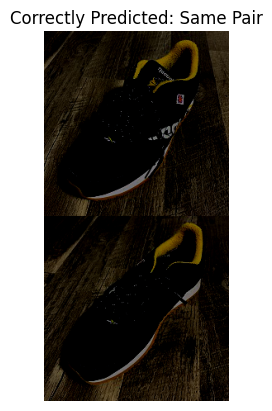

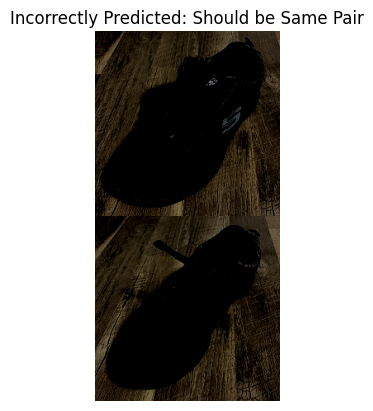

In [32]:
# Write your code here.
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1) Generate the positive (same) pairs for men's data
pos_data_men = generate_same_pair(test_m_data)  # shape => [num_pos, 448,224,3]

# 2) We'll search for:
#    - one correct classification (predicted 'same')
#    - one incorrect classification (should be 'same' but predicted 'different')

model.eval()

correct_found = None
incorrect_found = None

for i in range(len(pos_data_men)):
    # Single image => shape (448,224,3)
    x_np = pos_data_men[i]
    # Convert to PyTorch
    # if your model expects shape [N,3,448,224] or [N,6,224,224], adjust accordingly:
    x_torch = torch.from_numpy(x_np).permute(2,0,1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        outputs = model(x_torch)  # shape => (1,2)
        pred = outputs.argmax(dim=1).item()  # 0 or 1

    # '1' => predicted 'same', '0' => predicted 'different'
    if pred == 1:
        # correct prediction for a same-pair
        if correct_found is None:
            correct_found = i
    else:
        # incorrect prediction for a same-pair
        if incorrect_found is None:
            incorrect_found = i

    # If we've found both, we can stop
    if correct_found is not None and incorrect_found is not None:
        break

# Helper to display a single image (448×224×3)
def show_image(img_np, title_str):
    # If you had subtracted 0.5 during training, do e.g. `img_disp = np.clip(img_np + 0.5, 0, 1)`
    img_disp = np.clip(img_np, 0, 1)
    plt.imshow(img_disp)
    plt.title(title_str)
    plt.axis('off')
    plt.show()

# 3) Display the correct example
if correct_found is not None:
    show_image(pos_data_men[correct_found], "Correctly Predicted: Same Pair")
else:
    print("No correct same-pair classification found.")

# 4) Display the incorrect example
if incorrect_found is not None:
    show_image(pos_data_men[incorrect_found], "Incorrectly Predicted: Should be Same Pair")
else:
    print("No incorrect same-pair classification found.")



### 4.2 Women's Shoes example

Display one set of women's shoes that your model correctly classified as being
from the same pair.

display one set of inputs that your model classified incorrectly.

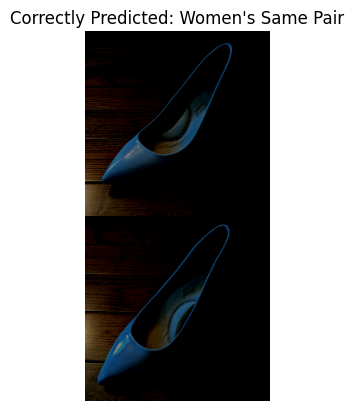

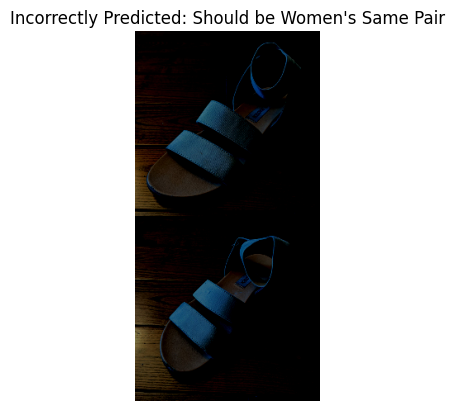

In [33]:
# Write your code here.
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1) Generate the positive (same) pairs for women's data
pos_data_women = generate_same_pair(test_w_data)  # shape => [num_pos, 448,224,3]

model.eval()

correct_found = None
incorrect_found = None

for i in range(len(pos_data_women)):
    # Single image => shape (448,224,3)
    x_np = pos_data_women[i]
    # Convert to PyTorch. If your model needs (N,3,448,224) or (N,6,224,224), adapt accordingly:
    x_torch = torch.from_numpy(x_np).permute(2,0,1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        outputs = model(x_torch)  # shape => (1,2)
        pred = outputs.argmax(dim=1).item()  # 0 or 1

    # '1' => predicted 'same', '0' => predicted 'different'
    if pred == 1:
        # correct classification for a same-pair
        if correct_found is None:
            correct_found = i
    else:
        # incorrect classification for a same-pair
        if incorrect_found is None:
            incorrect_found = i

    # If we've found both, break early
    if correct_found is not None and incorrect_found is not None:
        break

# Helper for displaying a single image
def show_image(img_np, title_str):
    # If your data was normalized to [-0.5,0.5], do e.g. img_disp=img_np+0.5
    img_disp = np.clip(img_np, 0, 1)
    plt.imshow(img_disp)
    plt.title(title_str)
    plt.axis('off')
    plt.show()

# 2) Display correct same-pair classification
if correct_found is not None:
    show_image(pos_data_women[correct_found],
               "Correctly Predicted: Women's Same Pair")
else:
    print("No correct same-pair classification found for women's shoes.")

# 3) Display incorrect same-pair classification
if incorrect_found is not None:
    show_image(pos_data_women[incorrect_found],
               "Incorrectly Predicted: Should be Women's Same Pair")
else:
    print("No incorrect same-pair classification found for women's shoes.")
